# Get image

In [ ]:
!wget https://file.hstatic.net/1000292100/article/61312315_440746569804333_4727353524977926144_n_9a585e47ace64345af4b2dd9bc1f45bb.jpg -O dog.jpg

--2024-11-11 13:51:15--  https://file.hstatic.net/1000292100/article/61312315_440746569804333_4727353524977926144_n_9a585e47ace64345af4b2dd9bc1f45bb.jpg
Resolving file.hstatic.net (file.hstatic.net)... 104.22.78.246, 104.22.79.246, 172.67.14.191, ...
Connecting to file.hstatic.net (file.hstatic.net)|104.22.78.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59012 (58K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>]  57.63K  --.-KB/s    in 0.008s  

2024-11-11 13:51:16 (7.36 MB/s) - ‘dog.jpg’ saved [59012/59012]



# Code for convert rgb to hsv

In [ ]:
import numpy as np
from numba import cuda
from PIL import Image

@cuda.jit
def rgb_to_hsv_cuda(rgb_array, hsv_array):
    # Get the 2D position of the thread in the array
    height, width = rgb_array.shape[0], rgb_array.shape[1]
    x, y = cuda.grid(2)  # 2D grid

    # Check bounds
    if x < height and y < width:
        r = rgb_array[x, y, 0] / 255.0
        g = rgb_array[x, y, 1] / 255.0
        b = rgb_array[x, y, 2] / 255.0

        c_max = max(r, g, b)
        c_min = min(r, g, b)
        delta = c_max - c_min

        # Calculate Hue
        if delta == 0:
            h = 0.0
        elif c_max == r:
            h = (60 * ((g - b) / delta) + 360) % 360
        elif c_max == g:
            h = (60 * ((b - r) / delta) + 120) % 360
        else:  # c_max == b
            h = (60 * ((r - g) / delta) + 240) % 360

        # Calculate Saturation
        s = 0.0 if c_max == 0 else (delta / c_max)

        # Value
        v = c_max

        hsv_array[x, y, 0] = h
        hsv_array[x, y, 1] = s
        hsv_array[x, y, 2] = v

img = Image.open('/content/dog.jpg')
rgb_data = np.array(img)


def convert_rgb_to_hsv(rgb_data, threads_per_block_x = 16,threads_per_block_y = 16):
    height, width, _ = rgb_data.shape
    hsv_data = np.zeros((height, width, 3), dtype=np.float32)
    blocks_per_grid_x = (height + (threads_per_block_x - 1)) // threads_per_block_x
    blocks_per_grid_y = (width + (threads_per_block_y - 1)) // threads_per_block_y
    rgb_device = cuda.to_device(rgb_data)
    hsv_device = cuda.to_device(hsv_data)
    rgb_to_hsv_cuda[(blocks_per_grid_x, blocks_per_grid_y), (threads_per_block_x, threads_per_block_y)](rgb_device, hsv_device)
    hsv_data = hsv_device.copy_to_host()
    return hsv_data

hsv_data = convert_rgb_to_hsv(rgb_data)

print(hsv_data[0])


[[3.5400000e+02 3.9840639e-02 9.8431373e-01]
 [3.5400000e+02 3.9840639e-02 9.8431373e-01]
 [3.5400000e+02 3.9840639e-02 9.8431373e-01]
 ...
 [3.0000000e+01 3.2978722e-01 7.3725492e-01]
 [2.8474577e+01 2.8640777e-01 8.0784315e-01]
 [2.8965517e+01 2.4369748e-01 9.3333334e-01]]


In [ ]:
print(hsv_data.shape)

(960, 960, 3)


In [ ]:
print(hsv_data[0].shape)

(960, 3)


# CPU version

Time taken: 130.084046125412 seconds


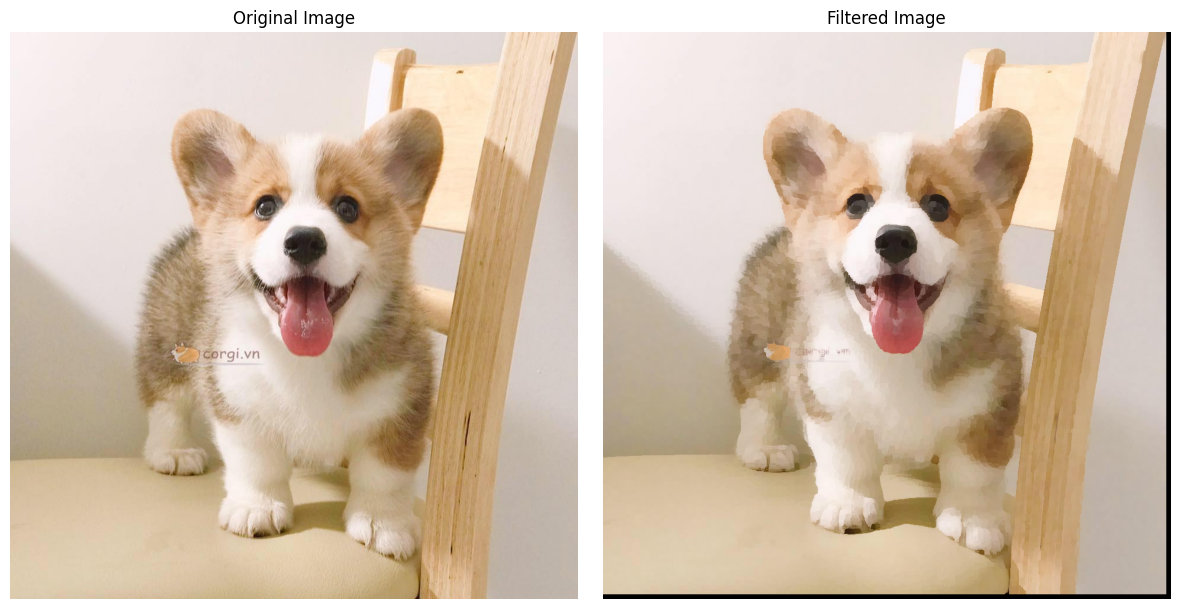

In [ ]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import time
from matplotlib.colors import rgb_to_hsv

def kuwahara_filter_hsv(img_rgb, img_hsv, kernel_size=5): # padded
    # Ensure kernel size is odd and >= 3
    if kernel_size % 2 == 0 or kernel_size < 3:
        raise ValueError("Kernel size must be an odd number greater than or equal to 3")

    pad_size = kernel_size // 2
    padded_v_channel = img_hsv[:, :, 2]


    filtered_image = np.zeros_like(img_rgb)

    for y in range(pad_size, padded_v_channel.shape[0] - pad_size):
        for x in range(pad_size, padded_v_channel.shape[1] - pad_size):
            v_regions_var = []
            for i in range(2):
                for j in range(2):
                    v_region = padded_v_channel[y - i * pad_size: y + (1 - i) * pad_size + 1,
                                              x - j * pad_size: x + (1 - j) * pad_size + 1]
                    v_regions_var.append((np.var(v_region),i,j))

            selected_region = min(v_regions_var, key=lambda x: x[0])
            i = selected_region[1]
            j = selected_region[2]

            # find the quadrant for rgb image to calc value for each pixel
            for t in range(3):
                region = img_rgb[:, :, t][y - i * pad_size: y + (1 - i) * pad_size + 1,
                                          x - j * pad_size: x + (1 - j) * pad_size + 1]
                mean_region = np.mean(region)
                filtered_image[:, :, t][y - pad_size, x - pad_size] = mean_region

    return filtered_image
###############################################################################

image_rgb = Image.open('/content/dog.jpg')
kernel_size = 9
pad_size = kernel_size // 2

padded_rgb = ImageOps.expand(image_rgb, border=pad_size, fill='black')
padded_rgb = np.array(padded_rgb)
padded_hsv = convert_rgb_to_hsv(padded_rgb)

# Start the timer
start_time = time.time()

filtered_image = kuwahara_filter_hsv(padded_rgb, padded_hsv, kernel_size= kernel_size)

# End the timer
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

###############################################################################

# Display the original and filtered images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
axes[0].imshow(image_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')  # Hide the axis

# Display the filtered image
axes[1].imshow(filtered_image)
axes[1].set_title('Filtered Image')
axes[1].axis('off')  # Hide the axis

plt.tight_layout()
plt.show()


# Without-shared memory

Time taken: 0.428879976272583 seconds


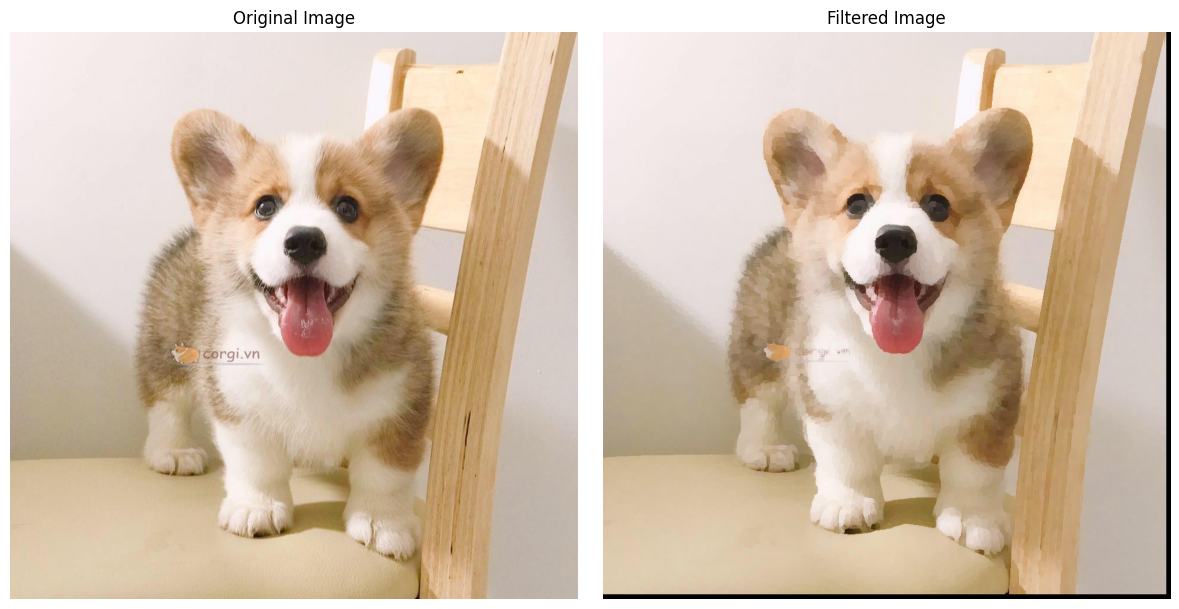

In [ ]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from numba import cuda, float32
import time

@cuda.jit
def kuwahara_filter_hsv_cuda(img_rgb, img_hsv, filtered_image, kernel_size):
    x, y = cuda.grid(2)
    pad_size = kernel_size // 2

    if y >= pad_size and y < img_hsv.shape[0] - pad_size and x >= pad_size and x < img_hsv.shape[1] - pad_size:
        min_variance = float32(1e10)
        selected_i = 0
        selected_j = 0

        for i in range(2):
            for j in range(2):
                v_sum = 0.0
                v_sum_sq = 0.0
                count = 0

                for dy in range(-pad_size * i, (1 - i) * pad_size + 1):
                    for dx in range(-pad_size * j, (1 - j) * pad_size + 1):
                        v = img_hsv[y + dy, x + dx, 2]  # V channel in HSV
                        v_sum += v
                        v_sum_sq += v * v
                        count += 1

                mean = v_sum / count
                variance = (v_sum_sq / count) - mean * mean

                if variance < min_variance:
                    min_variance = variance
                    selected_i = i
                    selected_j = j

        # Calculate the mean color for the selected region and write to the output
        for t in range(3):  # RGB channels
            region_sum = 0.0
            count = 0

            for dy in range(-pad_size * selected_i, (1 - selected_i) * pad_size + 1):
                for dx in range(-pad_size * selected_j, (1 - selected_j) * pad_size + 1):
                    region_sum += img_rgb[y + dy, x + dx, t]
                    count += 1

            mean_region = region_sum / count
            filtered_image[y - pad_size, x - pad_size, t] = mean_region

###############################################################################
image_rgb = Image.open('/content/dog.jpg')
kernel_size = 9
pad_size = kernel_size // 2

padded_rgb = ImageOps.expand(image_rgb, border=pad_size, fill='black')
padded_rgb = np.array(padded_rgb, dtype=np.float32)
padded_hsv = convert_rgb_to_hsv(padded_rgb)

filtered_image = np.zeros_like(padded_rgb)

threadsperblock = (16, 16)
blockspergrid_x = int(np.ceil(padded_rgb.shape[1] / threadsperblock[0]))
blockspergrid_y = int(np.ceil(padded_rgb.shape[0] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

d_img_rgb = cuda.to_device(padded_rgb)
d_img_hsv = cuda.to_device(padded_hsv)
d_filtered_image = cuda.to_device(filtered_image)

# Start the timer
start_time = time.time()

# Apply Kuwahara filter using CUDA
kuwahara_filter_hsv_cuda[blockspergrid, threadsperblock](d_img_rgb, d_img_hsv, d_filtered_image, kernel_size)

# Copy the result back to the host
filtered_image = d_filtered_image.copy_to_host()

# End the timer
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

###############################################################################

# Display the original and filtered images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
axes[0].imshow(image_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')  # Hide the axis

# Display the filtered image
axes[1].imshow(filtered_image.astype(np.uint8))
axes[1].set_title('Filtered Image')
axes[1].axis('off')  # Hide the axis

plt.tight_layout()
plt.show()


# With-shared memory

Time taken: 0.655494213104248 seconds


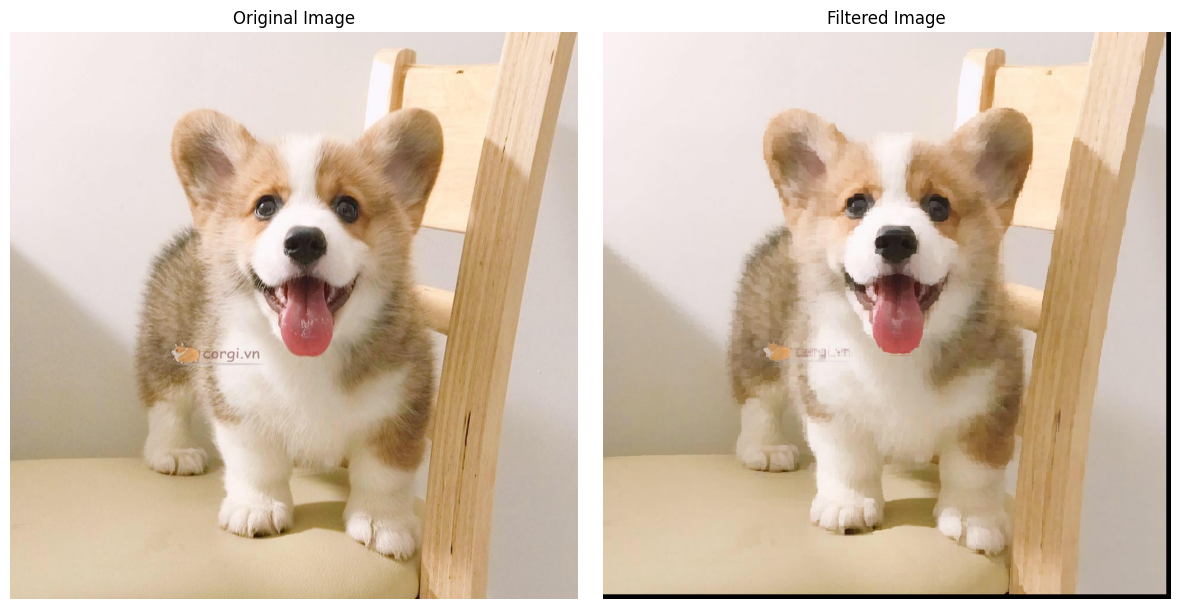

In [12]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from numba import cuda, float32
import time

@cuda.jit
def kuwahara_filter_hsv_cuda(img_rgb, img_hsv, filtered_image, kernel_size):
    x, y = cuda.grid(2)
    pad_size = kernel_size // 2

    shared_rgb = cuda.shared.array(shape=(32, 32, 3), dtype=float32)
    shared_v = cuda.shared.array(shape=(32, 32), dtype=float32)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    if y < img_rgb.shape[0] and x < img_rgb.shape[1]:
        shared_v[ty, tx] = img_hsv[y, x, 2]
        for c in range(3):  # Loop for the 3 channels
            shared_rgb[ty, tx, c] = img_rgb[y, x, c]


    cuda.syncthreads()

    if y >= pad_size and y < img_hsv.shape[0] - pad_size and x >= pad_size and x < img_hsv.shape[1] - pad_size:
        min_variance = float32(1e10)
        selected_i = 0
        selected_j = 0

        for i in range(2):
            for j in range(2):
                v_sum = 0.0
                v_sum_sq = 0.0
                count = 0

                for dy in range(-pad_size * i, (1 - i) * pad_size + 1):
                    for dx in range(-pad_size * j, (1 - j) * pad_size + 1):
                        local_y = ty + dy
                        local_x = tx + dx

                        if 0 <= local_y < 32 and 0 <= local_x < 32:
                            v = shared_v[local_y, local_x]  # V channel in HSV
                            v_sum += v
                            v_sum_sq += v * v
                            count += 1

                mean = v_sum / count
                variance = (v_sum_sq / count) - mean * mean

                # Check if this variance is the smallest found
                if variance < min_variance:
                    min_variance = variance
                    selected_i = i
                    selected_j = j

        # Calculate the mean color for the selected region and write to the output
        for t in range(3):  # RGB channels
            region_sum = 0.0
            count = 0

            for dy in range(-pad_size * selected_i, (1 - selected_i) * pad_size + 1):
                for dx in range(-pad_size * selected_j, (1 - selected_j) * pad_size + 1):
                    local_y = ty + dy
                    local_x = tx + dx

                    if 0 <= local_y < 32 and 0 <= local_x < 32:
                        region_sum += shared_rgb[local_y, local_x, t]
                        count += 1

            mean_region = region_sum / count
            filtered_image[y - pad_size, x - pad_size, t] = mean_region

###############################################################################

image_rgb = Image.open('/content/dog.jpg')
kernel_size = 9
pad_size = kernel_size // 2


padded_rgb = ImageOps.expand(image_rgb, border=pad_size, fill='black')
padded_rgb = np.array(padded_rgb, dtype=np.float32)
padded_hsv = convert_rgb_to_hsv(padded_rgb)


filtered_image = np.zeros_like(padded_rgb)


threadsperblock = (16, 16)
blockspergrid_x = int(np.ceil(padded_rgb.shape[1] / threadsperblock[0]))
blockspergrid_y = int(np.ceil(padded_rgb.shape[0] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)


d_img_rgb = cuda.to_device(padded_rgb)
d_img_hsv = cuda.to_device(padded_hsv)
d_filtered_image = cuda.to_device(filtered_image)

# Start the timer
start_time = time.time()

# Apply Kuwahara filter using CUDA
kuwahara_filter_hsv_cuda[blockspergrid, threadsperblock](d_img_rgb, d_img_hsv, d_filtered_image, kernel_size)

# Copy the result back to the host
filtered_image = d_filtered_image.copy_to_host()

# End the timer
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

###############################################################################

# Display the original and filtered images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
axes[0].imshow(image_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')  # Hide the axis

# Display the filtered image
axes[1].imshow(filtered_image.astype(np.uint8))
axes[1].set_title('Filtered Image')
axes[1].axis('off')  # Hide the axis

plt.tight_layout()
plt.show()
